In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
# Load in data
ts = pd.read_csv('Data/AR_lesson_ts.csv', index_col = 'date')
ts.head()

,dollars
date,
2020-01-05,0.422207
2020-01-12,-0.455290
2020-01-19,0.914767
2020-01-26,0.562761
2020-02-02,-0.649239


In [4]:
# Make index datetime
ts.index = pd.to_datetime(ts.index)
# We have weekly data so we will set our frequency to W
ts.index.freq= "W"
# Make a series
ts = ts['dollars']

In [5]:
# Check for nulls
ts.isna().sum().sum()

0

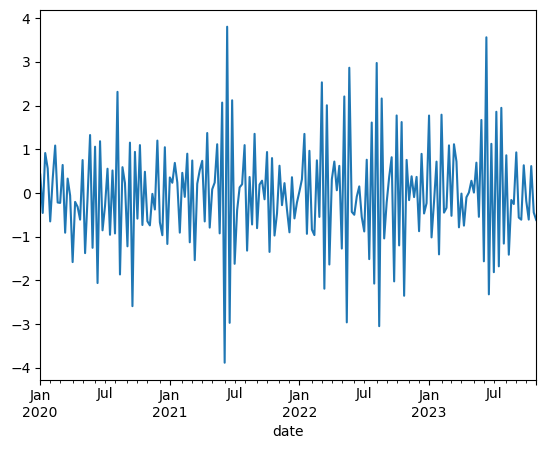

In [6]:
# Plot the time series
ts.plot();

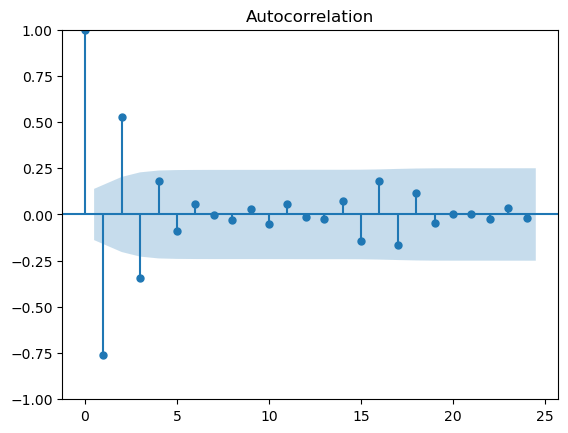

In [7]:
# Make acf plot of raw data to look for seasonality
tsa.graphics.plot_acf(ts);

In [8]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.612186,1,198,0.0,0.05,True


In [9]:
from pmdarima.arima.utils import ndiffs
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 0


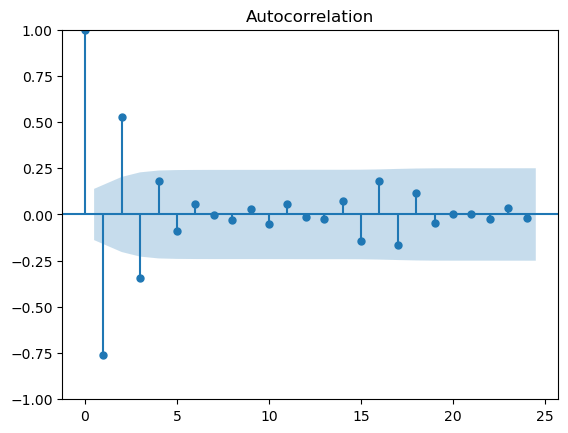

In [10]:
# Estimate Orders

# Make acf plot to determine if this is AR or MA 
tsa.graphics.plot_acf(ts);

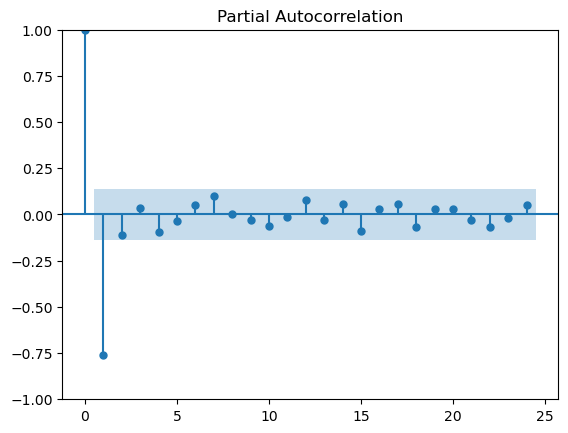

In [12]:
# PACF

# Examine the PACF plot to determine order of AR model
tsa.graphics.plot_pacf(ts);

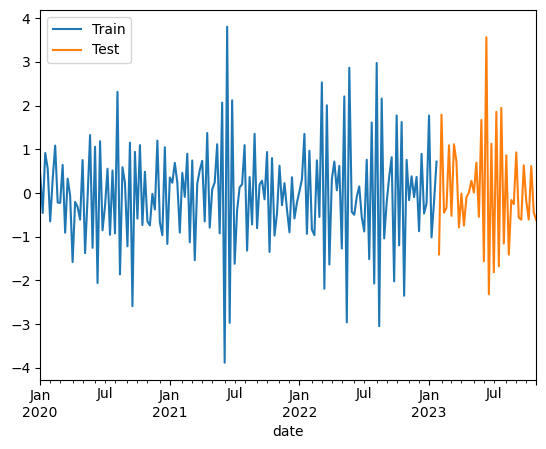

In [14]:
# Validation Split

from pmdarima.model_selection import train_test_split
# tts
train, test = train_test_split(ts, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [15]:
# Statsmodels

# proper way to import tsa submodule
import statsmodels.tsa.api as tsa

In [16]:
# ARIMA (AR only)

# First define the orders (p,d,q)
p = 1 # AR(1) model based on significant lags in PACF
d = 0 # No differcing needed to make stationary
q = 0 # q will be used for MA models (set to 0 for an AR only model)
# Now instantiate the model with the data and fit
ar_1_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_1_model

In [17]:
# Obtain the parameters of the fit model
ar_1_model.params

const    -0.033178
ar.L1    -0.754862
sigma2    0.626342
dtype: float64

In [18]:
# How to get a forecast from an ARIMA model

# Obtain forecast as a dataframe with confidence intervals
forecast_df = ar_1_model.get_forecast(steps=len(test)).summary_frame()
forecast_df.head()

dollars,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-29,-0.600555,0.791418,-2.151706,0.950595
2023-02-05,0.395113,0.991585,-1.548359,2.338585
2023-02-12,-0.356479,1.089316,-2.491499,1.778541
2023-02-19,0.210869,1.141267,-2.025974,2.447712
2023-02-26,-0.217400,1.169839,-2.510242,2.075441


In [19]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

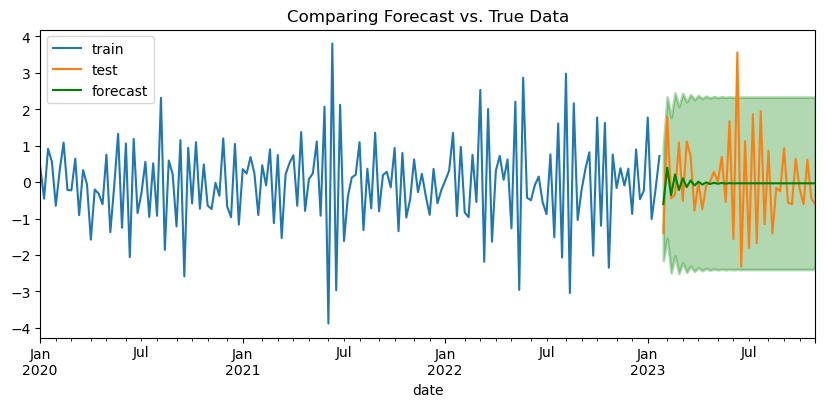

In [20]:
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [22]:
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.905
- MSE = 1.354
- RMSE = 1.164
- R^2 = 0.035
- MAPE = 120.08%
